In [74]:
# Set up working directory & Import necessary
import os
os.chdir('/Users/zepedalab/Desktop/MATHia_NLP_YB')

import pandas as pd # for manipulating dataframe
import re # for regular expression
import spacy #for NLP analysis
#!python3 -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

In [75]:
# Import Data File
text_df = pd.read_excel('/Users/zepedalab/Desktop/MATHia_NLP_YB/NLP Dataset.xlsx')

In [76]:
# Pre-process the text data (text_df)
# Convert the text input to the lower case string
# Remove all non-alphabetic characters
text_df['input'] = text_df['input'].astype(str)
text_df['input'] = text_df['input'].str.lower()
text_df['input'] = text_df['input'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
# Filter out any input that comprise less than 3 characters
text_df = text_df[text_df['input'].str.len() >= 3]
short_input_df = text_df[text_df['input'].str.len() < 3] #short_input_df allows us to manually check

In [77]:
# Detecting the nonsense string
from nostril import nonsense
short_indices = []
nonsense_indices = []

# Iterate through rows and separate nonsense rows
for index, row in text_df.iterrows():
    try:
        text = row['input']
        if len(text) < 6: # Check if the text is too short to test
            # Add the short text to short_text_df
            if len(text) < 6:
                short_indices.append(index)
            continue

        # Use nostril to detect nonsense in the current row's text
        if nonsense(text):
            nonsense_indices.append(index)

    except Exception as e:
        msg = str(e)
        if "Text is too short to test" in msg:
             short_indices.append(index)
        else:
            print(f"Error processing row {index}: {e}")

short_text_df = text_df.loc[short_indices]
nonsense_df = text_df.loc[nonsense_indices]
text_df = text_df.drop(nonsense_indices)

In [78]:
# Quicklook on the first 10 nonsense string
nonsense_df.input[:10]

4                                  jjjnnknjmimkkikiilkin
99                                           ummmmmm idk
103    jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj...
159                                              yayyyyy
162    dddddddddddddddddddddddddddddddddddddddddddddd...
263                            iiiiiiiiiiiiiiiiiiiiii kj
359                                           v guvghibj
463                                             ndcfksdj
480                                   ibhuiygutgcytuyvjh
505                                               jkkkkk
Name: input, dtype: object

In [79]:
# Pre-process those shor input by using the gibberish detector
from gibberish_detector import detector
Detector = detector.create_from_model('/Users/zepedalab/PycharmProjects/MATHia-NLP-YB/gibberish-detector.model')

In [80]:
gibberish_indices = []

# Iterate through rows and separate gibberish rows
for index, row in text_df.iterrows():
    try:
        # Check if the row is gibberish
        is_gibberish = Detector.is_gibberish(row['input'])

        # If it is gibberish, add to the gibberish_df and remove from text_df_3
        if is_gibberish:
            gibberish_indices.append(index)

    except Exception as e:
        print(f"Error processing row {index}: {e}")

gibberish_df = text_df.loc[gibberish_indices]
text_df = text_df.drop(gibberish_indices)

In [81]:
# Quicklook on the first 10 gibberish string
gibberish_df.input[:10]

93      bruhhhh
111    r gtktnq
113         idk
190         idk
191         idk
193         kjh
213        kklj
246         idk
254        jhgj
258         idk
Name: input, dtype: object

In [82]:
# Load spacy model
nlp = spacy.load("en_core_web_lg")

# Define a helper function to process text using spaCy
def spacy_preprocessor(texts):
    processed_docs = []
    # disable parser and ner for speed since we only need tokenization/lemmatization
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):
        # Lemmatize, lowercase, remove stopwords and non-alphabetic chars
        tokens = [
            token.lemma_.lower()
            for token in doc
            if not token.is_stop and token.is_alpha
        ]
        processed_docs.append(tokens)
    return processed_docs

# Call the helper function for Tokenize and lemmatize
tokenized_docs = spacy_preprocessor(text_df['input'].astype(str))

# Add tokens to dataframe temporarily to keep alignment safe
text_df['tokens'] = tokenized_docs

# Filter rows where the token list is not empty
text_df_filtered = text_df[text_df['tokens'].map(len) > 0].copy()

# Create the filtered docs list for Gensim
filtered_docs = text_df_filtered['tokens'].tolist()

# Create the cleaned string representation
text_df_filtered["cleaned_input"] = text_df_filtered['tokens'].apply(lambda x: ' '.join(x))


In [83]:
import gensim
from gensim import corpora
# create empty dictionary from gensim library (for the vocabulary)
dictionary = gensim.corpora.Dictionary()
# iteratively add each doc to the bag-of-words corpus
bow_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in text_df_filtered["tokens"]]

In [84]:
import numpy as np

# Get vocab from dictionary
vocab = pd.Series(dictionary.token2id).index

# Sequence of numbers as long as the documents
index = range(len(bow_corpus))

# Create a pandas dataframe full of zeros.
bow_df = pd.DataFrame(data=np.zeros((len(bow_corpus), len(dictionary)), dtype=np.float32),
                  index=index, # row labels
                  columns=vocab) #column labels

# Add each word from the bag-of-words corpus to the matrix.
for idx in index:
  for id, freq in bow_corpus[idx]:
    bow_df.loc[idx,dictionary[id]] = freq

# Transpose the matrix for easy reading
bow_df

,awaly,time,well,nan,ask,classmate,classs,fellow,focus,help,...,motavite,unit,continue,fun,create,different,anymore,suffer,motivational,disiplince
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
563,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [85]:
# Calculating Inverse Document Frequency
num_documents = len(bow_df) #get the length of the documents

# function of idf
def idf(term):
  documents_containing_term = (bow_df[term] > 0).sum()    # sum of documents containing the term
  return np.log(num_documents+1/documents_containing_term+1)  # divide the number of documents by the num documents with the term and get the log.

# dictionary comprehension to apply the idf function to every word (column) in the bow_df DataFrame
idf = pd.Series({term:idf(term) for term in bow_df.columns}) # create dictionary with key value pair of term:idf(term)

#Calculate Term Frequency
# divide each token count by the total token count for the row.
tf_df = bow_df.div(bow_df.sum(axis='columns'), axis='rows')

#Calculate the TF-IDF score
tfidf_df = tf_df.copy().multiply(idf, axis='columns')
# make copy of tf_df that is tf/idf

# Quick view on tf-idf metrix
tfidf_df



,awaly,time,well,nan,ask,classmate,classs,fellow,focus,help,...,motavite,unit,continue,fun,create,different,anymore,suffer,motivational,disiplince
0,2.114627,2.114094,2.114114,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.000000,0.000000,0.000000,6.34214,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.000000,0.000000,0.000000,6.34214,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.000000,0.000000,0.000000,6.34214,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.00000,1.40939,0.704778,0.704876,0.704876,0.704692,0.704687,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,0.000000,0.000000,0.000000,6.34214,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
563,0.000000,0.000000,0.000000,6.34214,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
564,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.268776,0.000000
565,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.057313


In [86]:
# Force both objects to use the same simple index 0..N-1
text_df_filtered = text_df_filtered.reset_index(drop=True)
tfidf_df = tfidf_df.reset_index(drop=True)

# now they share the same index
assert all(text_df_filtered.index == tfidf_df.index)


In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def run_balanced_logreg_for_code(code_col, text_df_filtered, tfidf_df,
                                 balance_seed=12434, shuffle_seed=14312):
    """
    Train & test a logistic regression on a balanced sample
    for a single human code (e.g., 'Willpower', 'Effort', 'Performance').

    - Builds a balanced sub-dataset (equal 0/1) by random downsampling
    - Trains logistic regression on that balanced dataset
    - Evaluates ON THE SAME balanced dataset
    - Plots confusion matrix
    """

    print(f"\n======================== {code_col} ========================")

    # 1. Select the target human code, cleaning NA etc.
    col = text_df_filtered[code_col]

    # Convert to numeric, force anything non-numeric to NaN, then treat NaN as 0
    y_raw = pd.to_numeric(col, errors='coerce').fillna(0).astype(int)

    print("Unique values after cleaning:", sorted(y_raw.unique()))

    # 2. Make sure X (tfidf_df) and y share the same indices
    valid_idx = tfidf_df.index.intersection(y_raw.index)

    X = tfidf_df.loc[valid_idx]
    y = y_raw.loc[valid_idx]

    print("\nRaw class counts:")
    print(y.value_counts())

    # Need both classes present
    if y.nunique() < 2:
        print(f"Not enough variation in {code_col} (only one class).")
        return None, None, None

    # 3. Build a balanced sub-dataset with equal number of 0 and 1
    class_counts = y.value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()
    n_minority = class_counts.min()

    minority_idx = y[y == minority_class].index
    majority_idx_sampled = y[y == majority_class].sample(
        n=n_minority,
        random_state=balance_seed  # reproducibility
    ).index

    balanced_idx = minority_idx.union(majority_idx_sampled)

    X_bal = X.loc[balanced_idx]
    y_bal = y.loc[balanced_idx]

    # 4. Shuffle rows
    X_bal, y_bal = shuffle(X_bal, y_bal, random_state=shuffle_seed)

    print("\nBalanced class counts:")
    print(y_bal.value_counts())

    # 5. Train logistic regression on the balanced dataset
    bal_classifier = LogisticRegression(max_iter=1000)
    bal_classifier.fit(X_bal, y_bal)

    print("\nClasses in classifier:", bal_classifier.classes_)

    # 6. Predict on the SAME balanced data
    predicted_bal = bal_classifier.predict(X_bal)

    # 7. Evaluation metrics
    print("\nLogistic Regression Accuracy (Balanced Data):",
          metrics.accuracy_score(y_bal, predicted_bal))
    print("Logistic Regression Precision (Balanced Data):",
          metrics.precision_score(y_bal, predicted_bal, zero_division=0))
    print("Logistic Regression Recall (Balanced Data):",
          metrics.recall_score(y_bal, predicted_bal, zero_division=0))

    print("\nClassification Report (Balanced Data):\n",
          metrics.classification_report(y_bal, predicted_bal, zero_division=0))

    # 8. Confusion matrix
    cm_bal = metrics.confusion_matrix(y_bal, predicted_bal)
    sns.heatmap(cm_bal, annot=True, fmt='d')
    plt.title(f'Confusion Matrix – {code_col} (Balanced Data)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return bal_classifier, X_bal, y_bal


In [88]:
def reduced_feature_model_only(clf, X_bal, y_bal, code_name,
                               k_pos=20, k_neg=20):
    """
    Build and evaluate a reduced logistic regression model using:
    - top k_pos positive coefficients
    - top k_neg negative coefficients
    Evaluate on the same balanced dataset.
    """

    coef = clf.coef_[0]
    feature_names = X_bal.columns

    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coef': coef
    })

    # select top positive features
    pos_df = coef_df[coef_df['coef'] > 0].nlargest(k_pos, 'coef')

    # select top negative features
    neg_df = coef_df[coef_df['coef'] < 0].nsmallest(k_neg, 'coef')

    # combine feature list
    selected_features = pd.concat([pos_df, neg_df])['feature'].unique().tolist()

    print(f"\n{code_name}: Selected {len(selected_features)} reduced features")
    # reduced dataset
    X_red = X_bal[selected_features]

    # fit reduced model
    clf_red = LogisticRegression(max_iter=1000)
    clf_red.fit(X_red, y_bal)

    # predictions
    y_pred = clf_red.predict(X_red)

    # performance report
    print("\nReduced Model Performance (Balanced Data):")
    print("Accuracy :", metrics.accuracy_score(y_bal, y_pred))
    print("Precision:", metrics.precision_score(y_bal, y_pred, zero_division=0))
    print("Recall   :", metrics.recall_score(y_bal, y_pred, zero_division=0))

    print("\nClassification Report:\n",
          metrics.classification_report(y_bal, y_pred, zero_division=0))

    # Confusion matrix
    cm = metrics.confusion_matrix(y_bal, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Reduced Confusion Matrix – {code_name}')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return clf_red, X_red, selected_features



Running REDUCED MODEL for Willpower

======================== Willpower ========================
Unique values after cleaning: [np.int64(0), np.int64(1)]

Raw class counts:
Willpower
0    466
1    101
Name: count, dtype: int64

Balanced class counts:
Willpower
0    101
1    101
Name: count, dtype: int64

Classes in classifier: [0 1]

Logistic Regression Accuracy (Balanced Data): 0.9752475247524752
Logistic Regression Precision (Balanced Data): 0.9615384615384616
Logistic Regression Recall (Balanced Data): 0.9900990099009901

Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       101
           1       0.96      0.99      0.98       101

    accuracy                           0.98       202
   macro avg       0.98      0.98      0.98       202
weighted avg       0.98      0.98      0.98       202



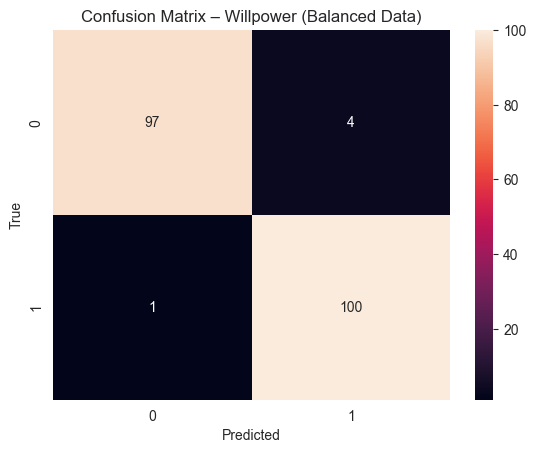


Willpower: Selected 40 reduced features

Reduced Model Performance (Balanced Data):
Accuracy : 0.9108910891089109
Precision: 0.9368421052631579
Recall   : 0.8811881188118812

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       101
           1       0.94      0.88      0.91       101

    accuracy                           0.91       202
   macro avg       0.91      0.91      0.91       202
weighted avg       0.91      0.91      0.91       202



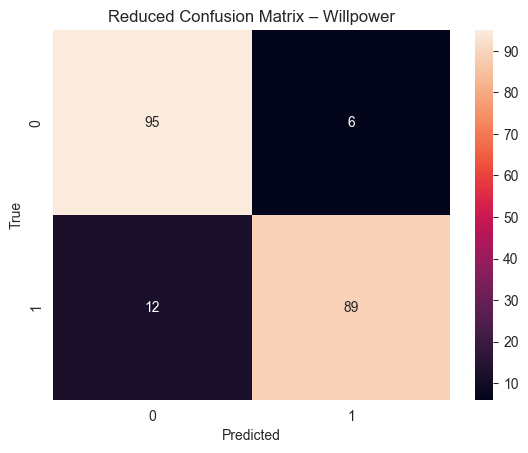


Running REDUCED MODEL for Performance Self-Talk

======================== Performance Self-Talk ========================
Unique values after cleaning: [np.int64(0), np.int64(1)]

Raw class counts:
Performance Self-Talk
0    517
1     50
Name: count, dtype: int64

Balanced class counts:
Performance Self-Talk
1    50
0    50
Name: count, dtype: int64

Classes in classifier: [0 1]

Logistic Regression Accuracy (Balanced Data): 0.98
Logistic Regression Precision (Balanced Data): 0.98
Logistic Regression Recall (Balanced Data): 0.98

Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       0.98      0.98      0.98        50

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



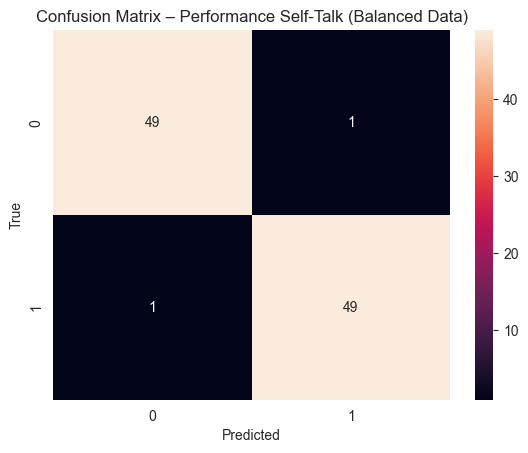


Performance Self-Talk: Selected 40 reduced features

Reduced Model Performance (Balanced Data):
Accuracy : 0.96
Precision: 0.9791666666666666
Recall   : 0.94

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96        50
           1       0.98      0.94      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



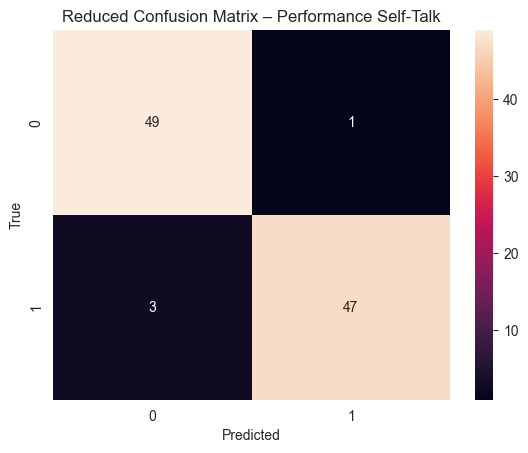


Running REDUCED MODEL for Effort

======================== Effort ========================
Unique values after cleaning: [np.int64(0), np.int64(1)]

Raw class counts:
Effort
0    524
1     43
Name: count, dtype: int64

Balanced class counts:
Effort
1    43
0    43
Name: count, dtype: int64

Classes in classifier: [0 1]

Logistic Regression Accuracy (Balanced Data): 0.9651162790697675
Logistic Regression Precision (Balanced Data): 0.9545454545454546
Logistic Regression Recall (Balanced Data): 0.9767441860465116

Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.95      0.98      0.97        43

    accuracy                           0.97        86
   macro avg       0.97      0.97      0.97        86
weighted avg       0.97      0.97      0.97        86



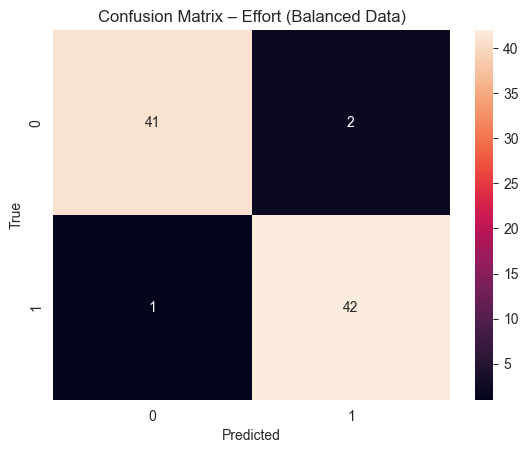


Effort: Selected 40 reduced features

Reduced Model Performance (Balanced Data):
Accuracy : 0.9302325581395349
Precision: 0.8936170212765957
Recall   : 0.9767441860465116

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.93        43
           1       0.89      0.98      0.93        43

    accuracy                           0.93        86
   macro avg       0.93      0.93      0.93        86
weighted avg       0.93      0.93      0.93        86



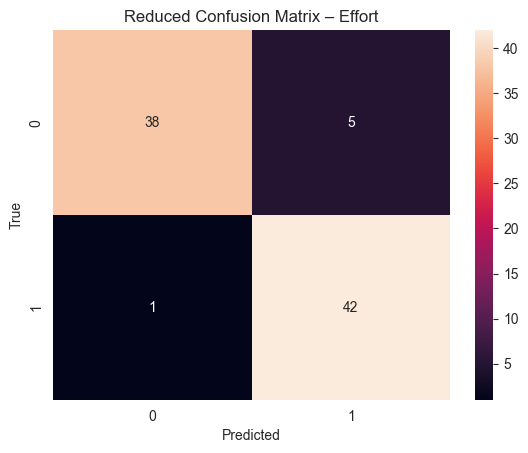

In [89]:
codes = ['Willpower', 'Performance Self-Talk', 'Effort']

reduced_results = {}

for code in codes:
    print("\n==============================")
    print(f"Running REDUCED MODEL for {code}")
    print("==============================")

    # Step 1: get balanced dataset + full model
    clf_full, X_bal, y_bal = run_balanced_logreg_for_code(
        code_col=code,
        text_df_filtered=text_df_filtered,
        tfidf_df=tfidf_df
    )

    # Step 2: reduced model ONLY
    clf_red, X_red, feature_list = reduced_feature_model_only(
        clf=clf_full,
        X_bal=X_bal,
        y_bal=y_bal,
        code_name=code,
        k_pos=20,
        k_neg=20
    )

    # save only reduced model results
    reduced_results[code] = {
        'clf_reduced': clf_red,
        'X_red': X_red,
        'features': feature_list,
        'y_bal': y_bal
    }


In [90]:
def make_side_by_side_table(pos, neg, code_name):
    # Convert to DataFrames with consistent column names
    df_pos = pos.reset_index()
    df_pos.columns = ['Positive Feature', 'Positive Weight']

    df_neg = neg.reset_index()
    df_neg.columns = ['Negative Feature', 'Negative Weight']

    # pad shorter column so lengths match
    max_len = max(len(df_pos), len(df_neg))

    df_pos = df_pos.reindex(range(max_len))
    df_neg = df_neg.reindex(range(max_len))

    table = pd.concat([df_pos, df_neg], axis=1)

    print(f"\n=== {code_name}: Positive vs. Negative Features ===")
    display(table)

    return table


In [91]:
def get_positive_negative_features(clf_red, X_red):
    coef = clf_red.coef_[0]
    coef_series = pd.Series(coef, index=X_red.columns)

    pos = coef_series[coef_series > 0].sort_values(ascending=False)
    neg = coef_series[coef_series < 0].sort_values()

    return pos, neg

side_by_side_tables = {}

for code in codes:
    print(f"\n\n==================== {code} ====================")

    clf_red = reduced_results[code]['clf_reduced']
    X_red = reduced_results[code]['X_red']

    # get pos/neg
    pos, neg = get_positive_negative_features(clf_red, X_red)

    # store the word lists for later spaCy similarity
    reduced_results[code]['pos_features'] = list(pos.index)
    reduced_results[code]['neg_features'] = list(neg.index)

    # produce and display table (if you still want it)
    table = make_side_by_side_table(pos, neg, code)
    side_by_side_tables[code] = table




==================== Willpower ====================

=== Willpower: Positive vs. Negative Features ===


,Positive Feature,Positive Weight,Negative Feature,Negative Weight
0,push,1.165332,math,-1.283940
1,tell,1.039203,grade,-1.204188
2,finish,0.915385,step,-0.915934
3,work,0.849784,nan,-0.751160
4,go,0.839109,evertung,-0.668616
5,want,0.819073,deadline,-0.659382
6,try,0.793052,fail,-0.647036
7,m,0.782412,solve,-0.628185
8,take,0.720557,calm,-0.625272
9,get,0.712252,think,-0.526277




==================== Performance Self-Talk ====================

=== Performance Self-Talk: Positive vs. Negative Features ===


,Positive Feature,Positive Weight,Negative Feature,Negative Weight
0,grade,1.962659,learn,-0.876974
1,well,1.035546,know,-0.803418
2,math,0.909864,hard,-0.689765
3,test,0.681394,outside,-0.683899
4,think,0.518392,nan,-0.657610
5,improve,0.506107,help,-0.586950
6,motivate,0.497325,say,-0.464250
7,pass,0.485570,fail,-0.446587
8,workspace,0.464091,collage,-0.442832
9,zero,0.449123,give,-0.432987




==================== Effort ====================

=== Effort: Positive vs. Negative Features ===


,Positive Feature,Positive Weight,Negative Feature,Negative Weight
0,wrong,0.906768,grade,-0.882722
1,everyday,0.791760,nan,-0.808904
2,understand,0.739335,want,-0.771588
3,reward,0.734563,fail,-0.703914
4,class,0.585021,finish,-0.698767
5,problem,0.570747,focused,-0.675813
6,solve,0.570059,candy,-0.646578
7,question,0.567657,evaluate,-0.599718
8,figure,0.516809,good,-0.588376
9,motivated,0.515246,not,-0.571243


In [92]:
pos, neg = get_positive_negative_features(clf_red, X_red)

reduced_results[code] = {
    'clf_reduced': clf_red,
    'X_red': X_red,
    'X_bal': X_bal,         # balanced TF-IDF rows
    'y_bal': y_bal,         # 0/1 labels for this code
    'pos_features': list(pos.index),
    'neg_features': list(neg.index)
}


In [105]:
from scipy.stats import ttest_ind

def spacy_similarity_for_code(code_name, reduced_results, text_df, text_col="input"):
    """
    For a given code (e.g., 'Willpower'):
      - get clf_reduced and X_red from reduced_results
      - compute positive features from clf_reduced
      - compute spaCy similarity for each balanced input (rows in X_red)
      - run a t-test comparing similarity scores for labels 0 vs 1
    """

    # 1) pull things out of reduced_results
    entry   = reduced_results[code_name]
    clf_red = entry['clf_reduced']
    X_red   = entry['X_red']      # reduced feature matrix (balanced rows)
    y_bal   = entry['y_bal']      # 0/1 labels aligned with X_red.index

    # 2) recompute positive features from this reduced model
    pos, neg = get_positive_negative_features(clf_red, X_red)
    pos_words = list(pos.index)

    if len(pos_words) == 0:
        print(f"No positive features found for {code_name}.")
        return None, None, None, (None, None)

    # 3) build reference spaCy doc from positive words
    ref_text = " ".join(pos_words)
    ref_doc  = nlp(ref_text)

    # 4) get the raw texts for the SAME rows as X_red
    texts = text_df.loc[X_red.index, text_col].fillna("")
    docs  = list(nlp.pipe(texts))

    # 5) compute similarity scores
    sim_scores = [doc.similarity(ref_doc) for doc in docs]
    sim_scores = pd.Series(sim_scores, index=X_red.index, name=f"{code_name}_sim")

    # 6) split by label and run t-test
    sims_0 = sim_scores[y_bal == 0]
    sims_1 = sim_scores[y_bal == 1]

    t, p = ttest_ind(sims_1, sims_0, equal_var=False)

    print(f"\n=== {code_name}: spaCy similarity t-test ===")
    print(f"Mean similarity (label 0): {sims_0.mean():.4f}  (n={len(sims_0)})")
    print(f"Mean similarity (label 1): {sims_1.mean():.4f}  (n={len(sims_1)})")
    print(f"t = {t:.4f}, p = {p:.4f}")

    return sim_scores, sims_0, sims_1, (t, p)


In [106]:
similarity_results = {}

for code in codes:
    sims, sims_0, sims_1, stats = spacy_similarity_for_code(
        code_name=code,
        reduced_results=reduced_results,
        text_df=text_df_filtered,
        text_col="input"   # change if your text column name is different
    )
    similarity_results[code] = {
        'scores': sims,
        'scores_0': sims_0,
        'scores_1': sims_1,
        't_test': stats
    }


=== Willpower: spaCy similarity t-test ===
Mean similarity (label 0): 0.5831  (n=101)
Mean similarity (label 1): 0.8462  (n=101)
t = 7.5953, p = 0.0000

=== Performance Self-Talk: spaCy similarity t-test ===
Mean similarity (label 0): 0.5776  (n=50)
Mean similarity (label 1): 0.8061  (n=50)
t = 4.8692, p = 0.0000

=== Effort: spaCy similarity t-test ===
Mean similarity (label 0): 0.5358  (n=43)
Mean similarity (label 1): 0.8406  (n=43)
t = 5.7232, p = 0.0000


/var/folders/13/9q4w_lnj0w5c08cw7_g1z1gr0000gn/T/ipykernel_6055/1211818967.py:35: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim_scores = [doc.similarity(ref_doc) for doc in docs]


In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all codes into one long dataframe
rows = []

for code in codes:   # ['Effort', 'Performance Self-Talk', 'Willpower']
    sims   = similarity_results[code]['scores']      # Series
    y_bal  = reduced_results[code]['y_bal']          # 0/1 labels

    # align indices just in case
    common_idx = sims.index.intersection(y_bal.index)
    sims_use   = sims.loc[common_idx]
    labels_use = y_bal.loc[common_idx]

    for idx in common_idx:
        rows.append({
            'code': code,
            'label': labels_use.loc[idx],
            'similarity': sims_use.loc[idx]
        })

plot_df = pd.DataFrame(rows)
plot_df['label'] = plot_df['label'].map({0: '0 (not coded)', 1: '1 (coded)'})


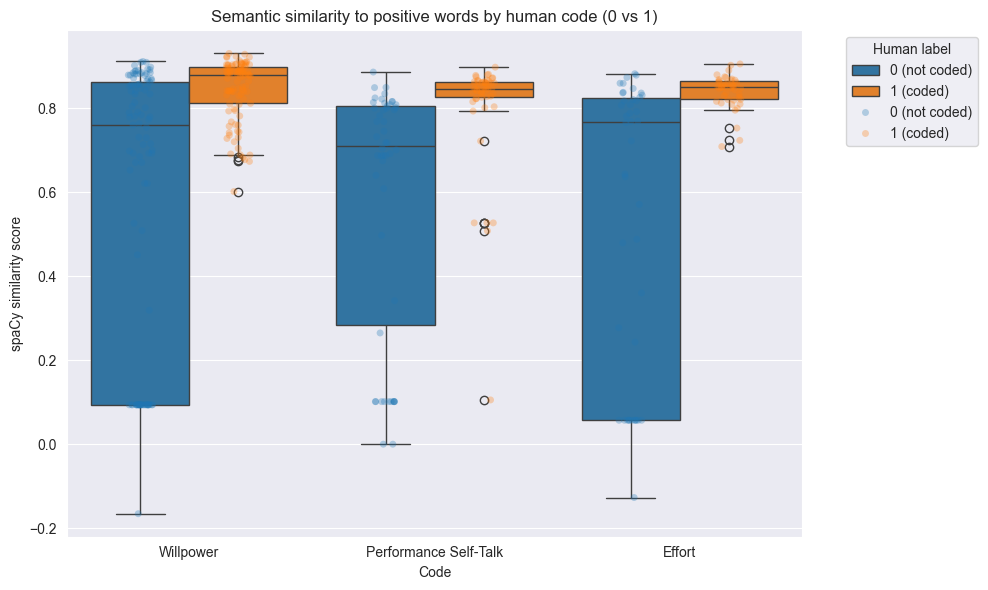

In [108]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_df, x='code', y='similarity', hue='label')
sns.stripplot(
    data=plot_df, x='code', y='similarity', hue='label',
    dodge=True, alpha=0.3, linewidth=0
)

plt.title("Semantic similarity to positive words by human code (0 vs 1)")
plt.ylabel("spaCy similarity score")
plt.xlabel("Code")
plt.legend(title="Human label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
